**Назаров Дмитрий Алексеевич 214-322**

# Задание 3 DAE

## Задание

Реализовать шумоподавляющий автоэнкодер (Denoising Autoencoder) на базе CIFAR-10 или MedMNIST, используя фреймворк Pytorch.

Также необходимо подобрать гиперпараметр размера для скрытого представления при улучшении или ухудшении результатов в выводах описать гипотезу почему ваши изменения привели к такому результату.

## Источники

* [Автоэнкодеры: типы архитектур и применение](https://neurohive.io/ru/osnovy-data-science/avtojenkoder-tipy-arhitektur-i-primenenie/)
* [Прикладное глубокое обучение - часть 3: автоэнкодеры](https://machinelearningmastery.ru/applied-deep-learning-part-3-autoencoders-1c083af4d798/#28b1)
* [Автокодировщик](https://neerc.ifmo.ru/wiki/index.php?title=%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
#  Задаем устройство для обучения
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Работаем на GPU')
else:
  device = torch.device('cpu')
  print('Работаем на CPU')

Работаем на CPU


## Создание DataLoader

В зависимости от выбранного датасета создаете соответствующий DataLoader используя цепочку transforms с нормализацией.

In [3]:
# С датасетами из MedMNIST идет модуль для python, который облегчает работу с ними. Ниже команда для установки и импорта этой библиотеки.

try:
    import medmnist
    print("module 'medmnist' is installed")
except ModuleNotFoundError:
    print("module 'medmnist' is not installed")
    # !pip install medmnist
    # import medmnist
    # print("Module 'medmnist' has been installed and imported")

from medmnist import INFO, Evaluator


data_flag = 'organcmnist'  # выбираем один из датасетов

info = INFO[data_flag]

DataClass = getattr(medmnist, info['python_class'])

task = info['task']

module 'medmnist' is installed


In [4]:
# Цепочка предобработки данных в transforms.Compose

# ***Начало вашего кода***
BATCH_SIZE = 128
data_transform = transforms.Compose([
    # transforms.Resize((32,32)),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[.5], std=[.5])
    transforms.ToTensor()
])
# ***Конец вашего кода***


# Загрузка данных и их разделение на выборки (Dataset'ы). В тестовую выборку возьмите по одному изображению каждого класса.

# ***Начало вашего кода***
# data_dir = 'mnist'

# train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
# test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)
# Загрузка данных и их разделение на выборки в датасете данные уже разделены на три подвыборки {'train': 13000, 'val': 2392, 'test': 8268}
train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset =  DataClass(split='val', transform=data_transform, download=True) # По аналогии с train_dataset создайте соответствующую подвыборку
test_dataset =  DataClass(split='test', transform=data_transform, download=True) # По аналогии с train_dataset создайте соответствующую подвыборку


# ***Конец вашего кода***

Using downloaded and verified file: C:\Users\Dmitr\.medmnist\organcmnist.npz
Using downloaded and verified file: C:\Users\Dmitr\.medmnist\organcmnist.npz
Using downloaded and verified file: C:\Users\Dmitr\.medmnist\organcmnist.npz


## Архитектура энкодера

1. Свёртка 3x3, шаг 1, паддинг 1, карты на входе в зависимости от типа изображений, 16 на выходе с активацией ReLU;
1. Свёртка 3x3, шаг 1, паддинг 1, 16 карт на входе, 16 на выходе с активацией ReLU;
1. Свёртка 3x3, шаг 2, паддинг 1, 16 карт на входе, 32 на выходе с активацией ReLU;
1. Свёртка 3x3, шаг 1, паддинг 1, 32 карты на входе, 32 на выходе с активацией ReLU;
1. Свёртка 3x3, шаг 2, паддинг 1, 32 карты на входе, 64 на выходе с активацией ReLU;
1. Свёртка 3x3, шаг 1, паддинг 1, 64 карты на входе, 64 на выходе с активацией ReLU;
1. Уплощение (nn.Flatten);
1. Полносвязный слой с активацией ReLU;

## Архитектура декодера

Количество входов и выходов в слоях свертки аналогично слоям энкодера, но в обратном порядке.

В итоге на входе энкодера и выходе декодера должны быть одинаковые размерности.

1. Полносвязный слой с активацией ReLU;
1. Двумерная транспонированная свертка (ConvTranspose2d), шаг 1, паддинг 1 с активацией ReLU;
1. Двумерная транспонированная свертка (ConvTranspose2d), шаг 2, паддинг 1 с активацией ReLU;
1. Двумерная транспонированная свертка (ConvTranspose2d), шаг 1, паддинг 1 с активацией ReLU;
1. Двумерная транспонированная свертка (ConvTranspose2d), шаг 2, паддинг 1 с активацией ReLU;
1. Двумерная транспонированная свертка (ConvTranspose2d), шаг 1, паддинг 1 с активацией ReLU;
1. Двумерная транспонированная свертка (ConvTranspose2d), шаг 1, паддинг 1 с активацией ReLU;

In [5]:
# Энкодер
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

Объединим энкодер и декодер в автоэнкодер

In [6]:
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.encoder.to(device)

    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [7]:
from skimage import img_as_float
from skimage.io import imread
from skimage.metrics import structural_similarity, mean_squared_error, peak_signal_noise_ratio

def getquality(image1, image2):
    image_float = img_as_float(image1)
    noise_float = img_as_float(image2)

    mse = mean_squared_error(image_float, noise_float)
    psnr = peak_signal_noise_ratio(image_float, noise_float)
    # ssim = structural_similarity(image_float, noise_float, channel_axis=2)

    print(f"MSE = {round(mse,5)}")
    print(f"PSNR = {round(psnr,5)}")
    # print(f"SSIM = {round(ssim,5)}\n")

Convolutional Autoencoder Architecture


In [8]:
class ConvolutionalAutoencoder():
  def __init__(self, autoencoder):
    self.network = autoencoder
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)

  def train(self, loss_function, epochs, batch_size, 
            training_set, validation_set, test_set):
    
    #  Словарь для логов
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'visualizations': []
    } 

    #  определяем функцию для инициализации параметров (весов)
    def init_weights(module):
      if isinstance(module, nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
      elif isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

    #  применяем функцию инициализации параметров для сети
    self.network.apply(init_weights)

    #  Создаем DataLoader'ы
    train_loader = DataLoader(training_set, batch_size)
    val_loader = DataLoader(validation_set, batch_size)
    test_loader = DataLoader(test_set, 10)

    #  Переключаем сеть в режим обучения
    self.network.train()
    self.network.to(device)

    for epoch in range(epochs):
      print(f'Эпоха {epoch+1}/{epochs}')
      train_losses = []
      
      # Обучение
      criterion = nn.CrossEntropyLoss()
      print('обучение...')
      for inputs, _ in tqdm(train_loader):

        # Шаги для обучения:
        # 1. загрузить изображения
        # 2. реконструировать изображение (прямой проход через энкодер и декодер)
        # 3. рассчитать `loss`
        # 4. выполнить `loss.backward ()` для вычисления градиентов функции потери относительно параметров модели
        # 5. выполнить шаг оптимизации `optimizer.step ()`
        # 6. занулить градиенты

        # ***Начало вашего кода***
        outp=self.network(inputs)
        # print(inputs.size())
        loss = loss_function(outp, inputs.view(-1, 1, 28, 28))
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        # ***Конец вашего кода***
        
        # Логирование
        log_dict['training_loss_per_batch'].append(loss.item())

      # Валидация
      print('валидация...')
      for val_images in tqdm(val_loader):
        with torch.no_grad():
          #  отправка изображений на устройство
          # print(val_images.size())
          val_images = val_images[0].to(device)
          #  восстановление изображений
          output = self.network(val_images)
          #  расчет потерь на валидации
          val_loss = loss_function(output, val_images.view(-1, 1, 28, 28))

        # Логирование
        log_dict['validation_loss_per_batch'].append(val_loss.item())


      # Визуализация
      print(f'Потери на обучающей: {round(loss.item(), 4)} потери на проверочной: {round(val_loss.item(), 4)}')
      testim=[]
      rec=[]
      for test_images in test_loader:
        test_images = test_images[0].to(device)
        with torch.no_grad():
          #  реконструируем тестовые изображения
          reconstructed_imgs = self.network(test_images)
        #  пересылаем их на цпу для визуализации
        reconstructed_imgs = reconstructed_imgs.cpu()
        test_images = test_images.cpu()
        rec=reconstructed_imgs
        testim=test_images
      
      imgs = torch.stack([testim.view(-1, 1, 28, 28), rec], dim=1).flatten(0,1)
      grid = make_grid(imgs, nrow=10, normalize=True, padding=1)
      grid = grid.permute(1, 2, 0)
      plt.figure(dpi=170)
      plt.title('Original/Reconstructed')
      plt.imshow(grid)
      log_dict['visualizations'].append(grid)
      plt.axis('off')
      plt.show()
      getquality(imgs[0], imgs[1])
      
    return log_dict

  def autoencode(self, x):
    return self.network(x)

  def encode(self, x):
    encoder = self.network.encoder
    return encoder(x)
  
  def decode(self, x):
    decoder = self.network.decoder
    return decoder(x)

## Обучение модели

Попробуйте разные размерности для скрытого представления (latent_dim) например от 100 до 2000. Сравните результаты.

Эпоха 1/10
обучение...


  0%|          | 0/102 [00:00<?, ?it/s]

валидация...


  0%|          | 0/19 [00:00<?, ?it/s]

Потери на обучающей: 0.0514 потери на проверочной: 0.0504


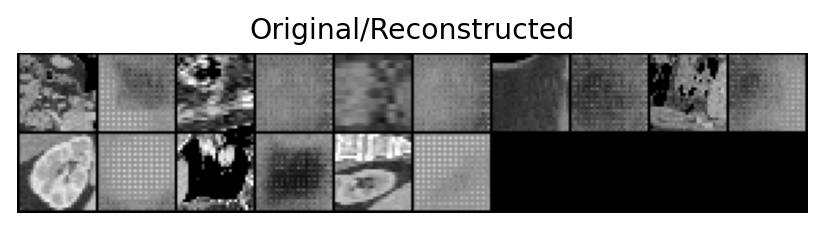

MSE = 0.04789
PSNR = 13.19735
Эпоха 2/10
обучение...


  0%|          | 0/102 [00:00<?, ?it/s]

валидация...


  0%|          | 0/19 [00:00<?, ?it/s]

Потери на обучающей: 0.0417 потери на проверочной: 0.0408


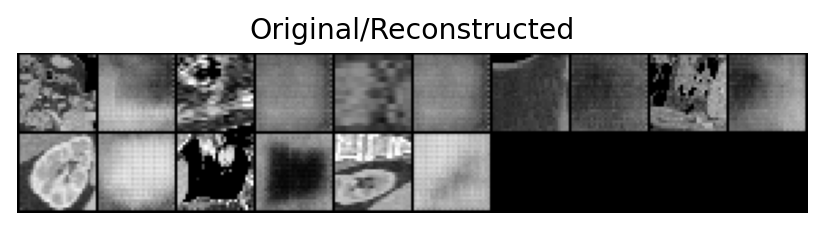

MSE = 0.0451
PSNR = 13.45865
Эпоха 3/10
обучение...


  0%|          | 0/102 [00:00<?, ?it/s]

валидация...


  0%|          | 0/19 [00:00<?, ?it/s]

Потери на обучающей: 0.0406 потери на проверочной: 0.0395


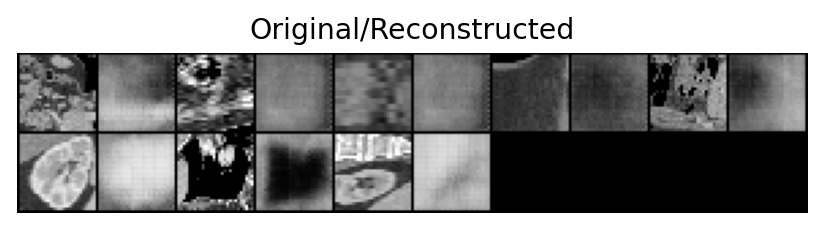

MSE = 0.04352
PSNR = 13.61308
Эпоха 4/10
обучение...


  0%|          | 0/102 [00:00<?, ?it/s]

валидация...


  0%|          | 0/19 [00:00<?, ?it/s]

Потери на обучающей: 0.04 потери на проверочной: 0.0386


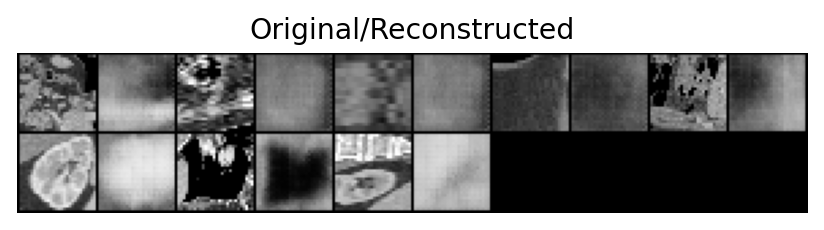

MSE = 0.04588
PSNR = 13.38369
Эпоха 5/10
обучение...


  0%|          | 0/102 [00:00<?, ?it/s]

валидация...


  0%|          | 0/19 [00:00<?, ?it/s]

Потери на обучающей: 0.0396 потери на проверочной: 0.0381


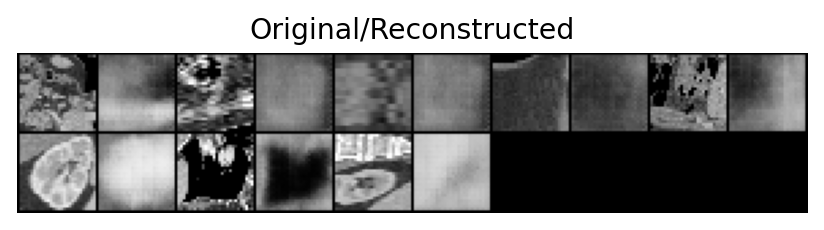

MSE = 0.04457
PSNR = 13.50933
Эпоха 6/10
обучение...


  0%|          | 0/102 [00:00<?, ?it/s]

валидация...


  0%|          | 0/19 [00:00<?, ?it/s]

Потери на обучающей: 0.0393 потери на проверочной: 0.0378


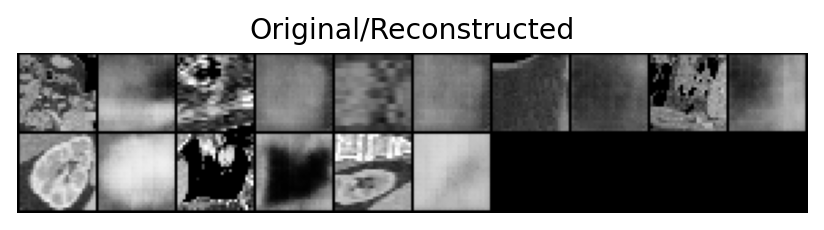

MSE = 0.0432
PSNR = 13.64532
Эпоха 7/10
обучение...


  0%|          | 0/102 [00:00<?, ?it/s]

валидация...


  0%|          | 0/19 [00:00<?, ?it/s]

Потери на обучающей: 0.039 потери на проверочной: 0.0374


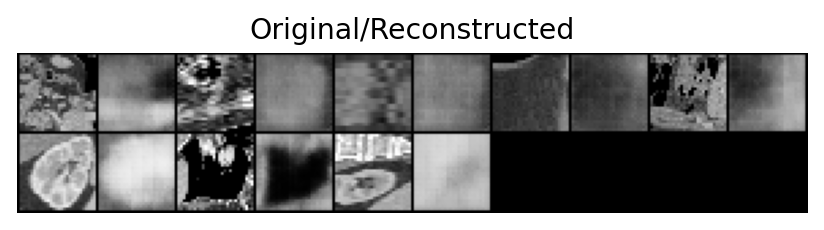

MSE = 0.04178
PSNR = 13.79014
Эпоха 8/10
обучение...


  0%|          | 0/102 [00:00<?, ?it/s]

валидация...


  0%|          | 0/19 [00:00<?, ?it/s]

Потери на обучающей: 0.0387 потери на проверочной: 0.0372


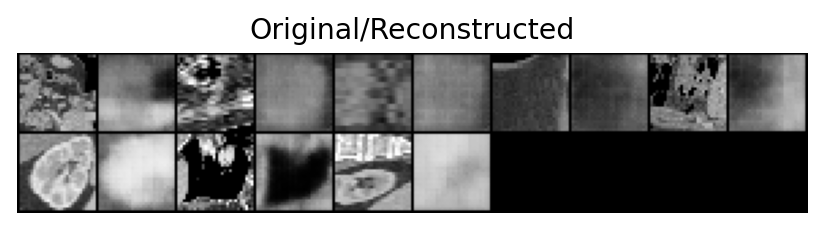

MSE = 0.0405
PSNR = 13.92545
Эпоха 9/10
обучение...


  0%|          | 0/102 [00:00<?, ?it/s]

валидация...


  0%|          | 0/19 [00:00<?, ?it/s]

Потери на обучающей: 0.0385 потери на проверочной: 0.037


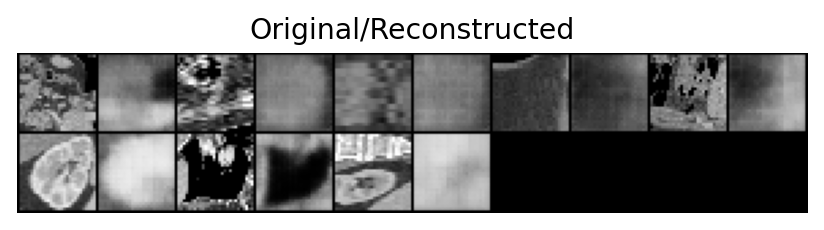

MSE = 0.04008
PSNR = 13.97064
Эпоха 10/10
обучение...


  0%|          | 0/102 [00:00<?, ?it/s]

валидация...


  0%|          | 0/19 [00:00<?, ?it/s]

Потери на обучающей: 0.0382 потери на проверочной: 0.0368


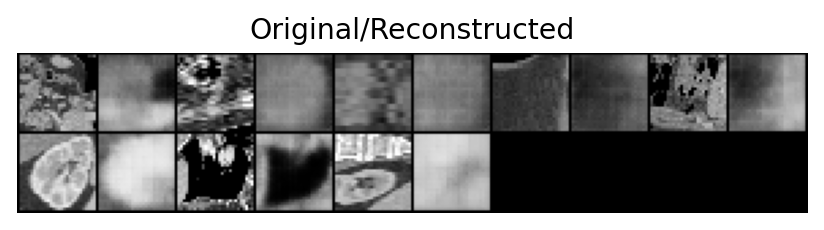

MSE = 0.04043
PSNR = 13.93281


In [9]:
model = ConvolutionalAutoencoder(Autoencoder(Encoder(encoded_space_dim=4,fc2_input_dim=128), Decoder(encoded_space_dim=4,fc2_input_dim=128)))

log_dict = model.train(nn.MSELoss(), epochs=10, batch_size=BATCH_SIZE, 
                       training_set=train_dataset, validation_set=val_dataset,
                       test_set=test_dataset)

С помощью метрик оценки качества изображений из прошлого семестра, провести сравнение работы разных моделей на нескольких изображениях и сделать выводы.

## Анализ данных

Проанализировать данные и сделать выводы о возможных проблемах.

1) Полученные изображения отчасти напоманиют оригинальные, однако достаточно сильно отличаются от исходников.
2) Низкая точность работы программы обусловлена неудачно сормированной архитектурой программного кода.
